##### Copyright Deloitte

# Chicago Taxi Geographic zones prediction (Model Deployment and Inference)


## Overview

This notebook is intended to showcase the steps taken to generate the inferences from a trained model for the Chicago Taxi Geographic zones prediction. Before we jump into the detailed steps used, let us get an eagle view of the entire process. Model Development has the following life cycle:

1. Data Preprocessing
2. Model Design and Training
3. Model Evaluation and HyperParameter Tuning
4. Model Deployment and Inference **[Here]**

Our current hypothesis dictates the prediction of the High Demand Geographic zones based on several factors (more details provided in the technical document and white paper). This notebook details primarily with the Model Deployment and Inference aspect of the Modeling Life Cycle and showcases the necessary steps required to run a prediction job using AI Platform.



## Model Deployment and Inference

The inferences from the trained model are generated for the month of January 2020. Information about the Splitting Method used is explained in the white paper and the technical document

### Data Preparation


For generating the inferences, the raw data has to be transformed into the right format before sending it to the model. This format is different for the generation of predictions directly from the notebook and different for generating the predictions from an AI Platform Job. Both these are documented below. The change in format only references to the way the data is presented but doesnt change the underlying data. For instance, if the value for `trip_total` is '12', both the formats send provide the said input. Further details are provided in the white paper and documentation

In [71]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import scikitplot as skplt
import matplotlib.pyplot as plt
from google.cloud import bigquery
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score, roc_auc_score


PROJECT_ID, DATASET_ID, TRAINING_TABLE_ID,  = 'us-gcp-ame-con-01e-npd-1.chcg_dtst.tx_trps_tst2'.split('.')

query = 'SELECT * FROM `{}`.{}.{}'.format( PROJECT_ID, DATASET_ID, TRAINING_TABLE_ID)

client = bigquery.Client(project=PROJECT_ID)

dataset_ref = client.dataset(DATASET_ID)

job_config = bigquery.QueryJobConfig()

query_job = client.query(query, job_config=job_config)

result = query_job.to_dataframe()

predictor = result.iloc[:,1:].pop('side')

transformed_df = result.iloc[:,1:-1]

transformed_df['crime_rating'] = np.round(transformed_df['crime_rating'],2)

dictionary_ = transformed_df.to_dict('list')

new_dictionary = {}

for key in dictionary_:
    
    if key in ['crime_rating','avg_prcp','avg_snow','avg_tavg','trip_total','trip_miles']:
        
        new_dictionary.update({key:np.array(dictionary_[key], dtype=np.float32)})
        
    else:
        
        new_dictionary.update({key:np.array(dictionary_[key])})


The Community Areas were converted into numbers in the Training set. This was to facilitate the process of building the model. The Raw Data set was untouched and only processed in BigQuery. Hence, the predictor has to be mapped to the numbers. The mapping for this is present in the `Community_area_mapping.csv`

In [72]:

mappings = dict(pd.read_csv("Community_area_mapping.csv").groupby(['Side', 'Side Number']).all().index)

actuals = predictor.apply(lambda x: mappings[x])


## Experiment One

### Prediction In Memory

The following cells demonstrate the process of generating the Predictions in Memory. This is done by loading the model into the RAM and calling the predict function on it.

In [73]:

model_one = tf.keras.models.load_model('gs://us-gcp-ame-con-01e-npd-1-modelartifacts/Experiment_One/v2/Experiment_One/export/')

predicted = model_one.predict_classes(new_dictionary)

predicted_probabilities = model_one.predict(new_dictionary)

In [78]:
from sklearn.metrics import classification_report
classification_report = classification_report(actuals, predicted,digits=8,  output_dict=True)

accuracy_score(actuals, predicted)


0.8952725569473005

In [82]:
df = pd.DataFrame(classification_report).transpose()
df

,precision,recall,f1-score,support
0,0.999566,0.955166,0.976862,424480.000000
1,0.949576,0.730618,0.825830,134571.000000
2,0.350061,0.768428,0.481001,8533.000000
3,0.142550,0.886432,0.245603,3663.000000
4,0.964944,0.915957,0.939812,46940.000000
5,0.395197,0.817548,0.532828,6884.000000
6,0.260748,0.481156,0.338212,21970.000000
7,0.815580,0.777238,0.795947,20165.000000
8,0.994485,0.976164,0.985239,109916.000000
accuracy,0.895273,0.895273,0.895273,0.895273


In [83]:
df.to_csv("classification_report_one.csv")

In [76]:
cohen_kappa_score(actuals, predicted)

0.8427615737350875

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

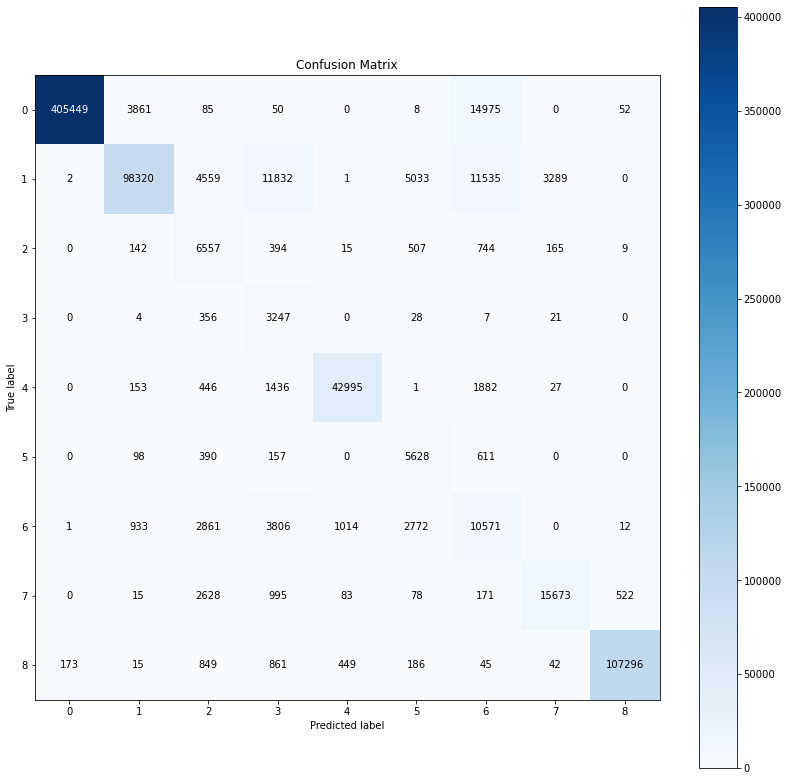

In [84]:
plt.rcParams['figure.figsize'] = (14, 14)
skplt.metrics.plot_confusion_matrix(actuals,predicted)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

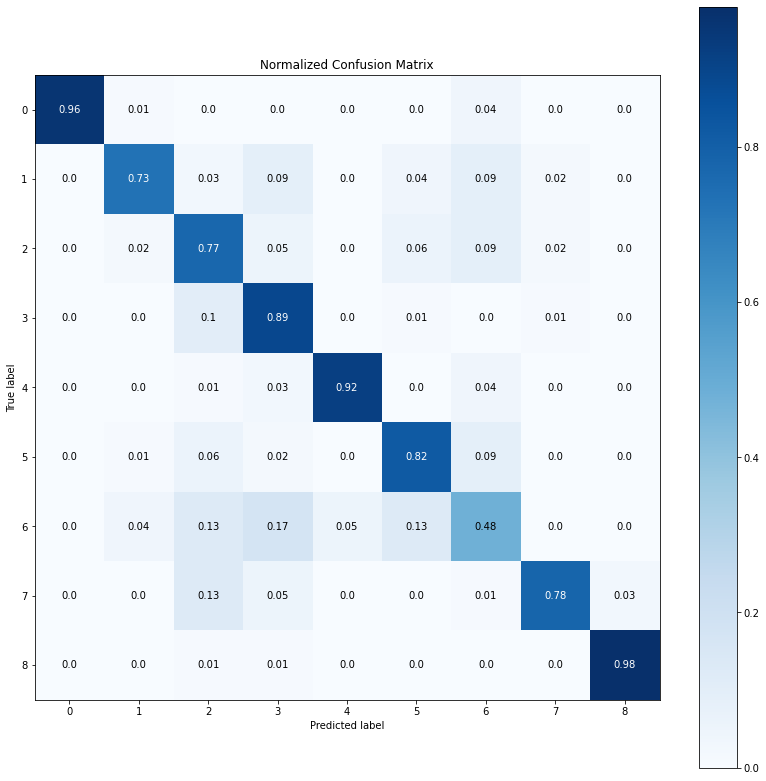

In [85]:
skplt.metrics.plot_confusion_matrix(actuals,predicted,normalize=True)

In [86]:
roc_auc_score(actuals,predicted_probabilities,multi_class='ovr')

0.9856737390305952

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


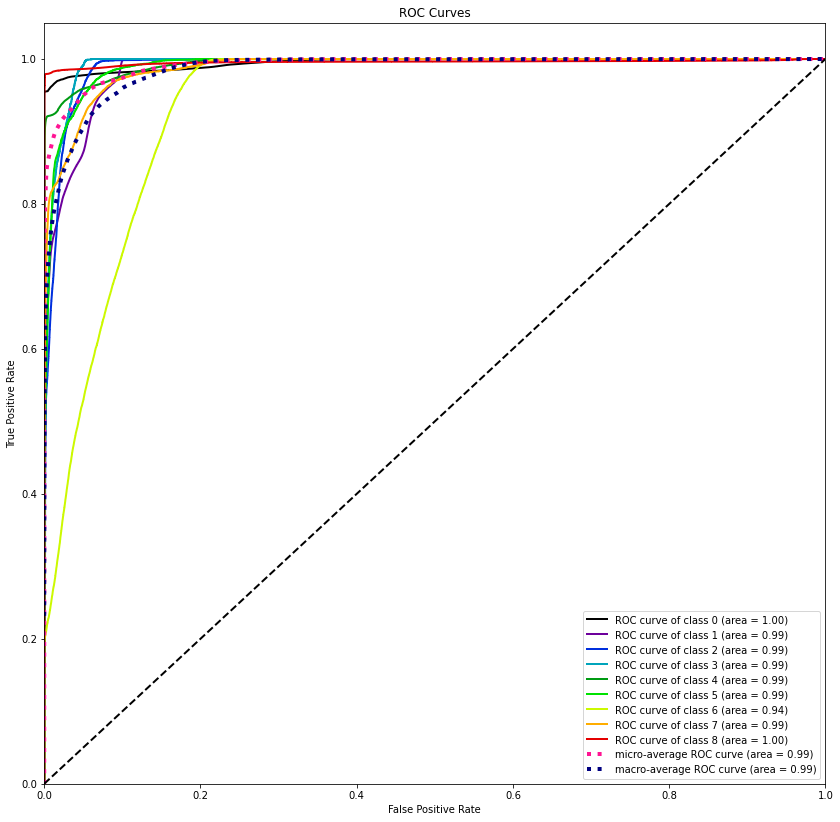

In [10]:
skplt.metrics.plot_roc_curve(actuals,predicted_probabilities)
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


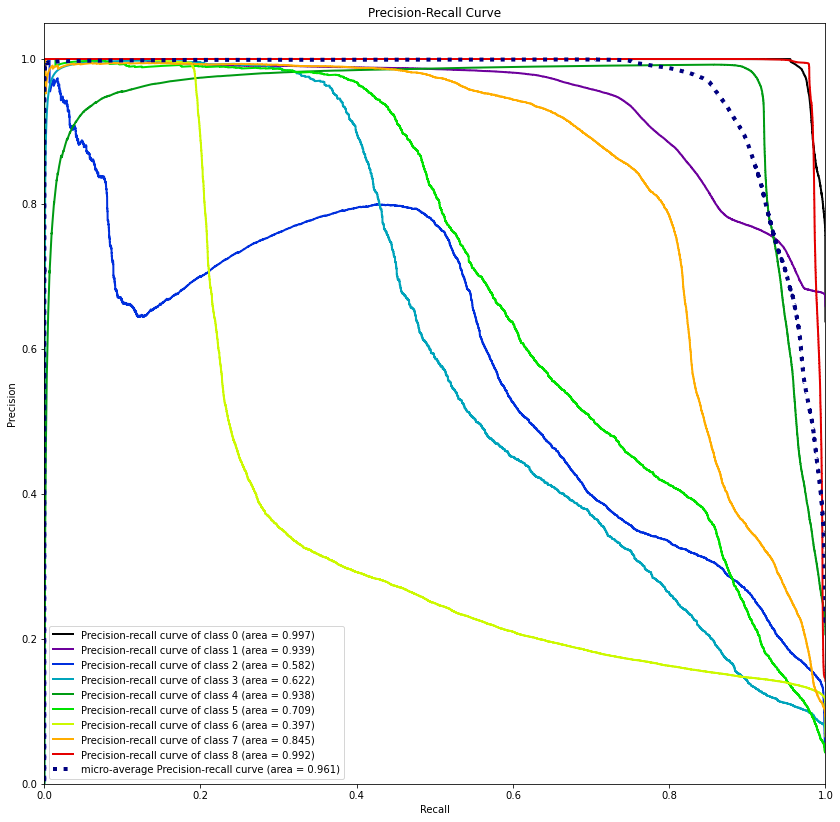

In [87]:
skplt.metrics.plot_precision_recall_curve(actuals,predicted_probabilities)
plt.savefig('one_precision.png')
plt.show()

In [12]:
pd.crosstab(actuals, predicted, dropna=False)

col_0,0,1,2,3,4,5,6,7,8
side,,,,,,,,,
0,405449,3861,85,50,0,8,14975,0,52
1,2,98320,4559,11832,1,5033,11535,3289,0
2,0,142,6557,394,15,507,744,165,9
3,0,4,356,3247,0,28,7,21,0
4,0,153,446,1436,42995,1,1882,27,0
5,0,98,390,157,0,5628,611,0,0
6,1,933,2861,3806,1014,2772,10571,0,12
7,0,15,2628,995,83,78,171,15673,522
8,173,15,849,861,449,186,45,42,107296


## Prediction on AI Platform

The following section prepares the data for a Batch Prediction on the AI Platform.

*Note : The Runtime Version we used doesnt support online predictions and hence, we havent demonstrated one with the online predictions. This is because the TensorFlow version that we are using is only available in the said Runtime Version*

### Defining the Configuration Variables

The following cell defines the Configuration Variables. 

*Note: The Model Name and version must match the Model name and Version given to the Model while training. This can be retreived from the Job that was used to create the model.*

In [ ]:
MODEL_NAME="Experiment_One"

REGION = "us-east4"

MODEL_VERSION="v2"

SAVED_MODEL_PATH="gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/{}/export".format(MODEL_NAME,MODEL_VERSION,MODEL_NAME)

INPUT_PATHS = 'gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/predictions/prediction_input.json'.format(MODEL_NAME,MODEL_VERSION)

OUTPUT_PATHS = 'gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/predictions/prediction_output'.format(MODEL_NAME,MODEL_VERSION)

DATA_FORMAT = 'text'

JOB_NAME = 'Experiment_One_v2_Prediction'

! Do not run the next cell if a Model with the above name already exists

In [ ]:
!gcloud ai-platform models create $MODEL_NAME \
  --region $REGION

#### Data Preparation for AI Platform Inference

In [ ]:
import json

dictionary_ = transformed_df.to_dict('row')

for value in dictionary_:
    
    for key in value:
        
        value[key] = [value[key]]

with open('prediction_input.json', 'w') as fp:
    
    for dictionary in dictionary_:
        
        json.dump(dictionary, fp)
        
        fp.write("\n")
        

Moving the predicted file to Google Storage since AI Platform only allows predictions from there

In [ ]:
!gsutil cp -r prediction_input.json $INPUT_PATHS

In [ ]:
!gcloud ai-platform jobs submit prediction $JOB_NAME \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATHS \
    --region $REGION \
    --model-dir $SAVED_MODEL_PATH \
    --runtime-version 2.1 \
    --data-format $DATA_FORMAT

#### Retriving the Predictions
Before we retrive the predictions, lets wait till the job completes. We can do this by streaming the logs 

In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

In [ ]:
!gsutil -m cp -r $OUTPUT_PATHS .

In [ ]:

values = []
for file in os.listdir('prediction_output'):
    if "results" in file:
        with open('prediction_output/'+file) as f:
            for line in f:
                dictionary_ = json.loads(line)
                values.append(np.argmax(dictionary_['output_1']))

In [ ]:
np.array(values)

In [ ]:
predicted

The values from the AI Platform job and the In Memory dont match all the time. This is because the AI Platform jobs run out of sequence.

## Experiment Two

### Prediction In Memory

The following cells demonstrate the process of generating the Predictions in Memory. This is done by loading the model into the RAM and calling the predict function on it.

In [88]:
#preprocessing data for Experiment Two

PROJECT_ID, DATASET_ID, TRAINING_TABLE_ID,  = 'us-gcp-ame-con-01e-npd-1.chcg_dtst.tx_trps_tst2'.split('.')

query = 'SELECT * FROM `{}`.{}.{}  WHERE trip_start_timestamp>=1609439400'.format( PROJECT_ID, DATASET_ID, TRAINING_TABLE_ID)

client = bigquery.Client(project=PROJECT_ID)

dataset_ref = client.dataset(DATASET_ID)

job_config = bigquery.QueryJobConfig()

query_job = client.query(query, job_config=job_config)

result = query_job.to_dataframe()

predictor = result.iloc[:,1:].pop('side')

transformed_df2021 = result.iloc[:,1:-1]

transformed_df2021['crime_rating'] = np.round(transformed_df2021['crime_rating'],2)

dictionary2021_ = transformed_df2021.to_dict('list')

new_dictionary_2021 = {}

for key in dictionary2021_:
    
    if key in ['crime_rating','avg_prcp','avg_snow','avg_tavg','trip_total','trip_miles']:
        
        new_dictionary_2021.update({key:np.array(dictionary2021_[key], dtype=np.float32)})
        
    else:
        
        new_dictionary_2021.update({key:np.array(dictionary2021_[key])})


In [89]:

mappings = dict(pd.read_csv("Community_area_mapping.csv").groupby(['Side', 'Side Number']).all().index)

actuals = predictor.apply(lambda x: mappings[x])


In [90]:

model_two = tf.keras.models.load_model('gs://us-gcp-ame-con-01e-npd-1-modelartifacts/Experiment_Two/v3/Experiment_Two/export/')

predicted = model_two.predict_classes(new_dictionary_2021)

predicted_probabilities = model_two.predict(new_dictionary_2021)

In [92]:
from sklearn.metrics import classification_report
classification_report = classification_report(actuals, predicted,digits=8,  output_dict=True)

accuracy_score(actuals, predicted)


0.7376639231284212

In [93]:
df = pd.DataFrame(classification_report).transpose()
df

,precision,recall,f1-score,support
0,0.994706,0.907680,0.949203,28358.000000
1,0.934930,0.549845,0.692450,24145.000000
2,0.366197,0.919763,0.523834,5060.000000
3,0.236990,0.824545,0.368163,2143.000000
4,0.918934,0.767778,0.836583,8578.000000
5,0.554270,0.593590,0.573256,2340.000000
6,0.442832,0.579474,0.502021,12004.000000
7,0.677715,0.505708,0.579211,5256.000000
8,0.989440,0.869375,0.925530,13688.000000
accuracy,0.737664,0.737664,0.737664,0.737664


In [95]:
df.to_csv("two_report.csv")

In [96]:
cohen_kappa_score(actuals, predicted)

0.6895790438250513

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

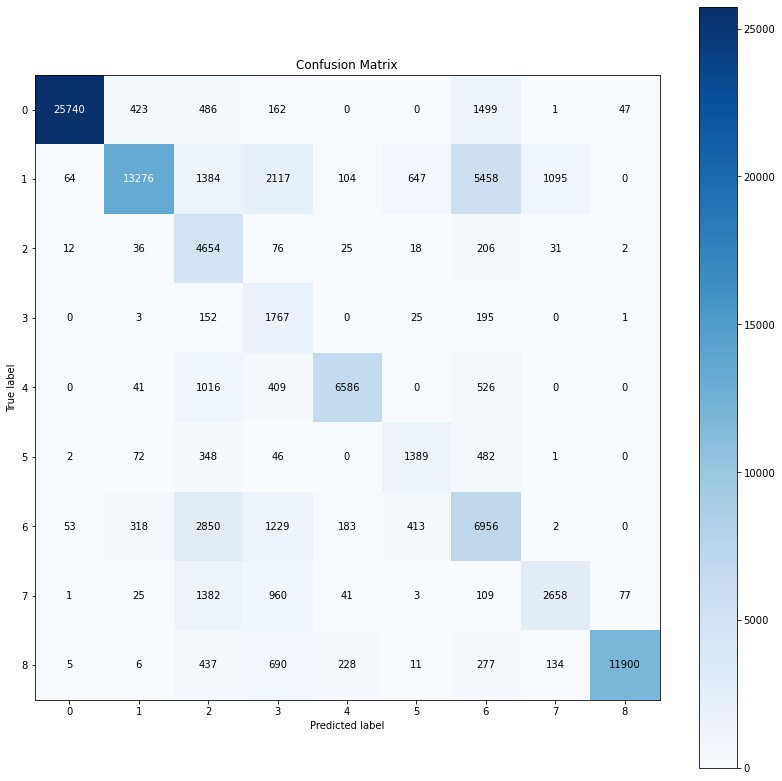

In [41]:
plt.rcParams['figure.figsize'] = (14, 14)
skplt.metrics.plot_confusion_matrix(actuals,predicted)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

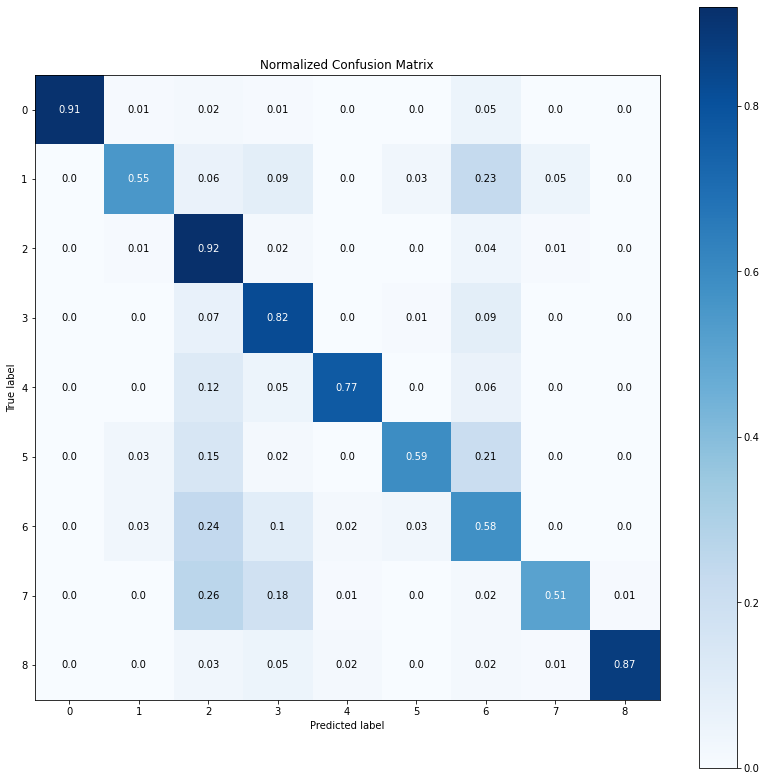

In [42]:
skplt.metrics.plot_confusion_matrix(actuals,predicted,normalize=True)

In [43]:
roc_auc_score(actuals,predicted_probabilities,multi_class='ovr')

0.9605044212669367

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


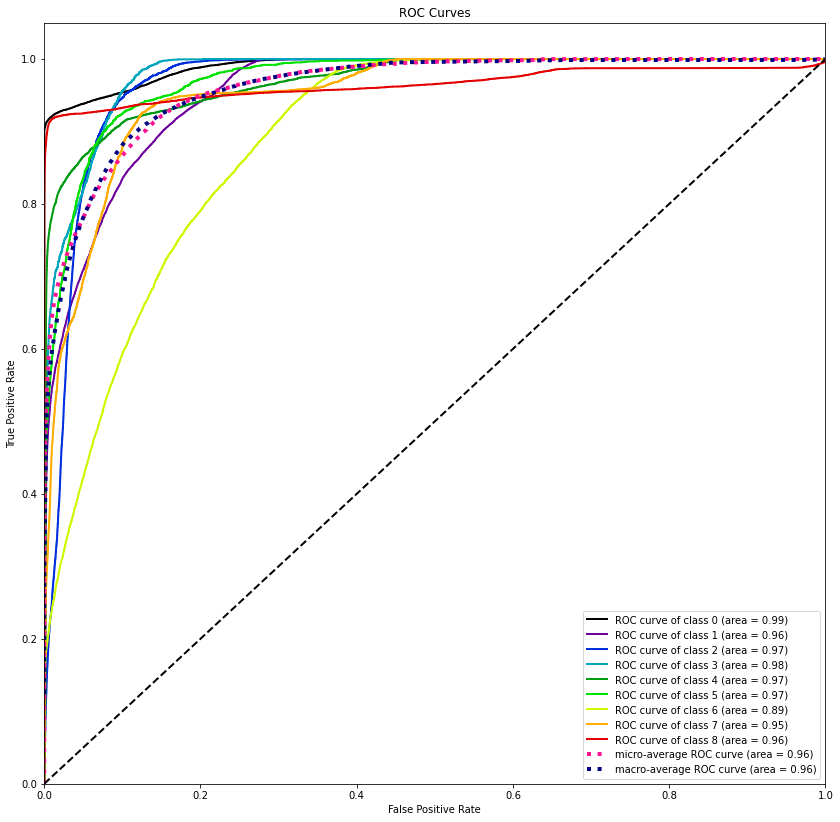

In [44]:
skplt.metrics.plot_roc_curve(actuals,predicted_probabilities)
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


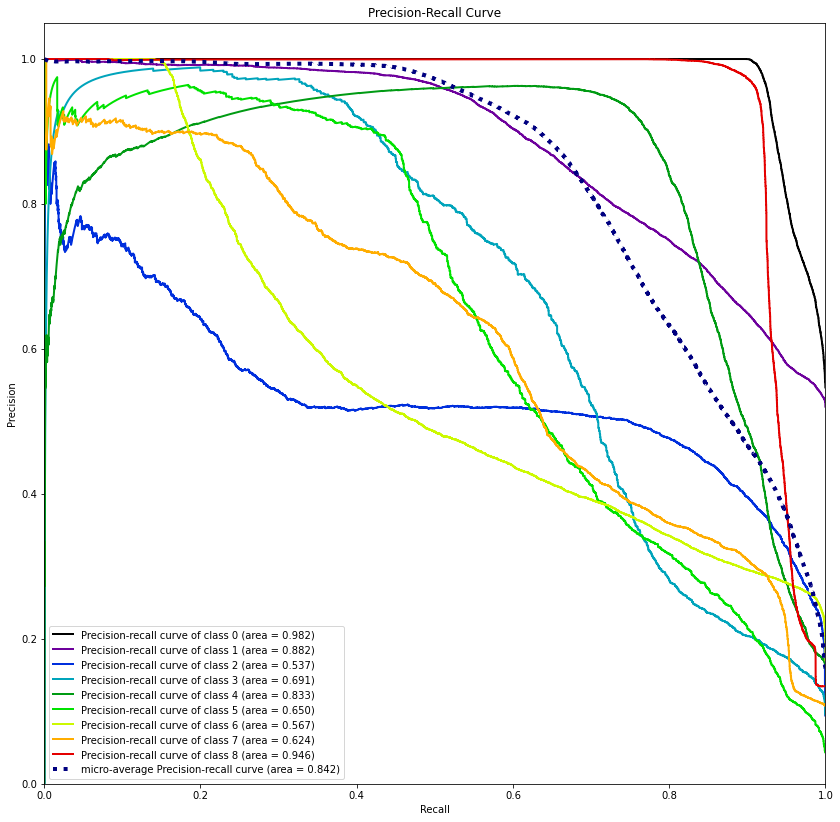

In [98]:
skplt.metrics.plot_precision_recall_curve(actuals,predicted_probabilities)
plt.savefig('two_precision.png')
plt.show()

In [46]:
pd.crosstab(actuals, predicted, dropna=False)

col_0,0,1,2,3,4,5,6,7,8
side,,,,,,,,,
0,25740,423,486,162,0,0,1499,1,47
1,64,13276,1384,2117,104,647,5458,1095,0
2,12,36,4654,76,25,18,206,31,2
3,0,3,152,1767,0,25,195,0,1
4,0,41,1016,409,6586,0,526,0,0
5,2,72,348,46,0,1389,482,1,0
6,53,318,2850,1229,183,413,6956,2,0
7,1,25,1382,960,41,3,109,2658,77
8,5,6,437,690,228,11,277,134,11900


## Prediction on AI Platform

The following section prepares the data for a Batch Prediction on the AI Platform.

*Note : The Runtime Version we used doesnt support online predictions and hence, we havent demonstrated one with the online predictions. This is because the TensorFlow version that we are using is only available in the said Runtime Version*

### Defining the Configuration Variables

The following cell defines the Configuration Variables. 

*Note: The Model Name and version must match the Model name and Version given to the Model while training. This can be retreived from the Job that was used to create the model.*

In [28]:
MODEL_NAME="Experiment_Two"

REGION = "us-east4"

MODEL_VERSION="v3"

SAVED_MODEL_PATH="gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/{}/export".format(MODEL_NAME,MODEL_VERSION,MODEL_NAME)

INPUT_PATHS = 'gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/predictions/prediction_input.json'.format(MODEL_NAME,MODEL_VERSION)

OUTPUT_PATHS = 'gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/predictions/prediction_output'.format(MODEL_NAME,MODEL_VERSION)

DATA_FORMAT = 'text'

JOB_NAME = 'Experiment_One_v3_Predictions'

! Do not run the next cell if a Model with the above name already exists

In [29]:
!gcloud ai-platform models create $MODEL_NAME \
  --region $REGION

Using endpoint [https://us-east4-ml.googleapis.com/]
Created ml engine model [projects/us-gcp-ame-con-01e-npd-1/models/Experiment_Two].


#### Data Preparation for AI Platform Inference

In [30]:
import json

dictionary_ = transformed_df2021.to_dict('row')

for value in dictionary_:
    
    for key in value:
        
        value[key] = [value[key]]

with open('prediction_input.json', 'w') as fp:
    
    for dictionary in dictionary_:
        
        json.dump(dictionary, fp)
        
        fp.write("\n")
        

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


Moving the predicted file to Google Storage since AI Platform only allows predictions from there

In [31]:
!gsutil cp -r prediction_input.json $INPUT_PATHS

Copying file://prediction_input.json [Content-Type=application/json]...
/ [1 files][ 23.3 MiB/ 23.3 MiB]                                                
Operation completed over 1 objects/23.3 MiB.                                     


In [32]:
!gcloud ai-platform jobs submit prediction $JOB_NAME \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATHS \
    --region $REGION \
    --model-dir $SAVED_MODEL_PATH \
    --runtime-version 2.1 \
    --data-format $DATA_FORMAT

Job [Experiment_One_v3_Predictions] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Experiment_One_v3_Predictions

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Experiment_One_v3_Predictions
jobId: Experiment_One_v3_Predictions
state: QUEUED


#### Retriving the Predictions
Before we retrive the predictions, lets wait till the job completes. We can do this by streaming the logs 

In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

In [ ]:
!gsutil -m cp -r $OUTPUT_PATHS .

In [ ]:

values = []
for file in os.listdir('prediction_output'):
    if "results" in file:
        with open('prediction_output/'+file) as f:
            for line in f:
                dictionary_ = json.loads(line)
                values.append(np.argmax(dictionary_['output_1']))

In [ ]:
np.array(values)

In [ ]:
predicted

The values from the AI Platform job and the In Memory dont match all the time. This is because the AI Platform jobs run out of sequence.

## Experiment Three

### Prediction In Memory

The following cells demonstrate the process of generating the Predictions in Memory. This is done by loading the model into the RAM and calling the predict function on it.

In [99]:
PROJECT_ID, DATASET_ID, TRAINING_TABLE_ID,  = 'us-gcp-ame-con-01e-npd-1.chcg_dtst.tx_trps_tst2'.split('.')

query = 'SELECT * FROM `{}`.{}.{}'.format( PROJECT_ID, DATASET_ID, TRAINING_TABLE_ID)

client = bigquery.Client(project=PROJECT_ID)

dataset_ref = client.dataset(DATASET_ID)

job_config = bigquery.QueryJobConfig()

query_job = client.query(query, job_config=job_config)

result = query_job.to_dataframe()

predictor = result.iloc[:,1:].pop('side')

drop_columns = ['payment_type','trip_miles','trip_total' ]



transformed_df = result.iloc[:,1:-1]

for column in drop_columns:
    drop = transformed_df.pop(column)

transformed_df['crime_rating'] = np.round(transformed_df['crime_rating'],2)

dictionary_ = transformed_df.to_dict('list')

new_dictionary = {}

for key in dictionary_:
    
    if key in ['crime_rating','avg_prcp','avg_snow','avg_tavg','trip_total','trip_miles']:
        
        new_dictionary.update({key:np.array(dictionary_[key], dtype=np.float32)})
        
    else:
        
        new_dictionary.update({key:np.array(dictionary_[key])})

In [100]:

mappings = dict(pd.read_csv("Community_area_mapping.csv").groupby(['Side', 'Side Number']).all().index)

actuals = predictor.apply(lambda x: mappings[x])


In [101]:

model_three = tf.keras.models.load_model('gs://us-gcp-ame-con-01e-npd-1-modelartifacts/Experiment_Three/v3/Experiment_Three/export/')

predicted = model_three.predict_classes(new_dictionary)

predicted_probabilities = model_three.predict(new_dictionary)

In [112]:
from sklearn.metrics import classification_report
classification_report = classification_report(actuals, predicted,digits=8, output_dict=True)

accuracy_score(actuals, predicted)


0.8456715933920286

In [113]:
df = pd.DataFrame(classification_report).transpose()
df

,precision,recall,f1-score,support
0,0.999747,0.947910,0.973139,424480.000000
1,0.793271,0.515490,0.624901,134571.000000
2,0.495622,0.404664,0.445548,8533.000000
3,0.116636,0.487305,0.188222,3663.000000
4,0.861554,0.899915,0.880317,46940.000000
5,0.163255,0.742592,0.267665,6884.000000
6,0.196610,0.481566,0.279222,21970.000000
7,0.688011,0.772626,0.727867,20165.000000
8,0.986748,0.970732,0.978674,109916.000000
accuracy,0.845672,0.845672,0.845672,0.845672


In [114]:
df.to_csv("classification_report_three.csv")

In [104]:
cohen_kappa_score(actuals, predicted)

0.7699589513818518

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

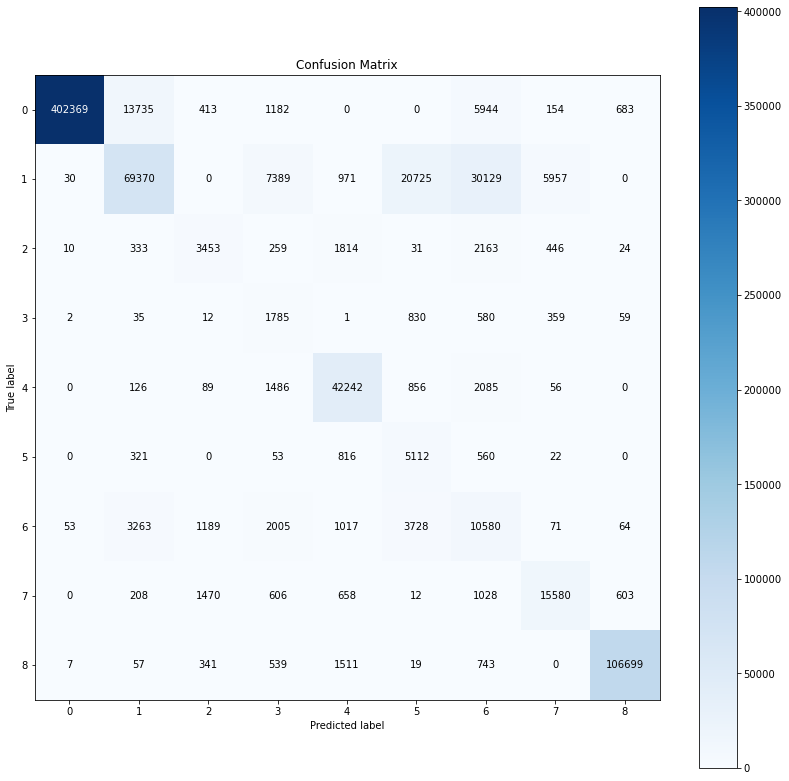

In [107]:
plt.rcParams['figure.figsize'] = (14, 14)
skplt.metrics.plot_confusion_matrix(actuals,predicted)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

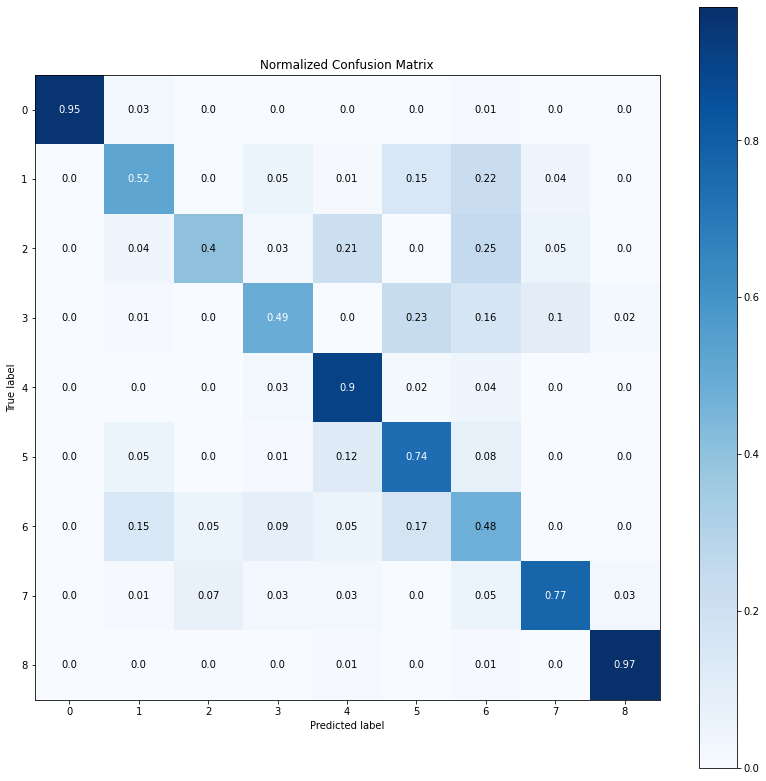

In [108]:
skplt.metrics.plot_confusion_matrix(actuals,predicted,normalize=True)

In [109]:
roc_auc_score(actuals,predicted_probabilities,multi_class='ovr')

0.9672501336685682

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


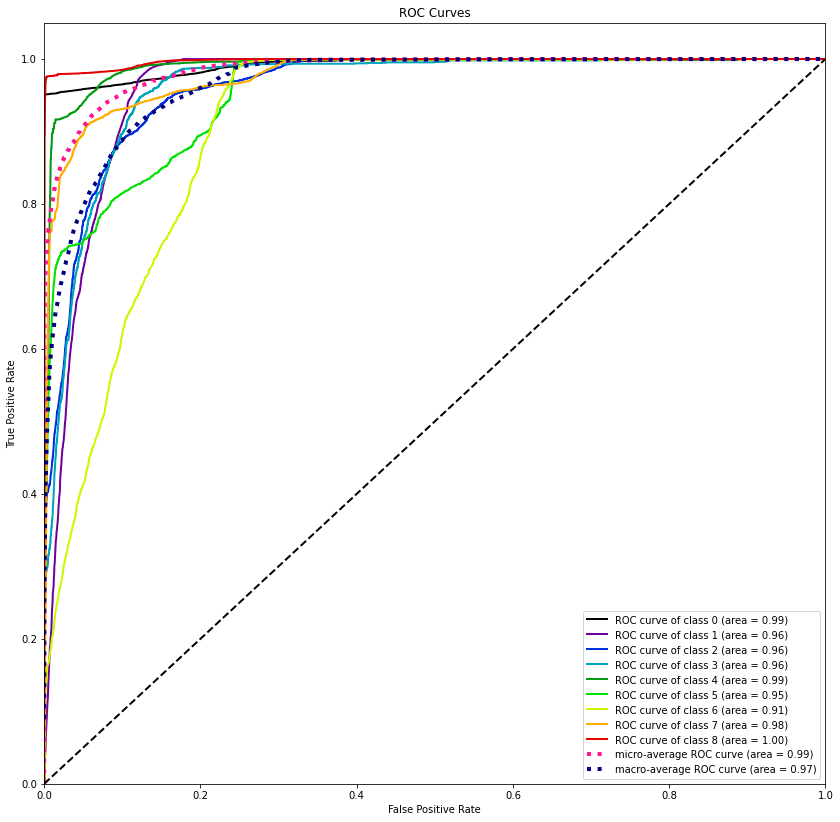

In [110]:
skplt.metrics.plot_roc_curve(actuals,predicted_probabilities)
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


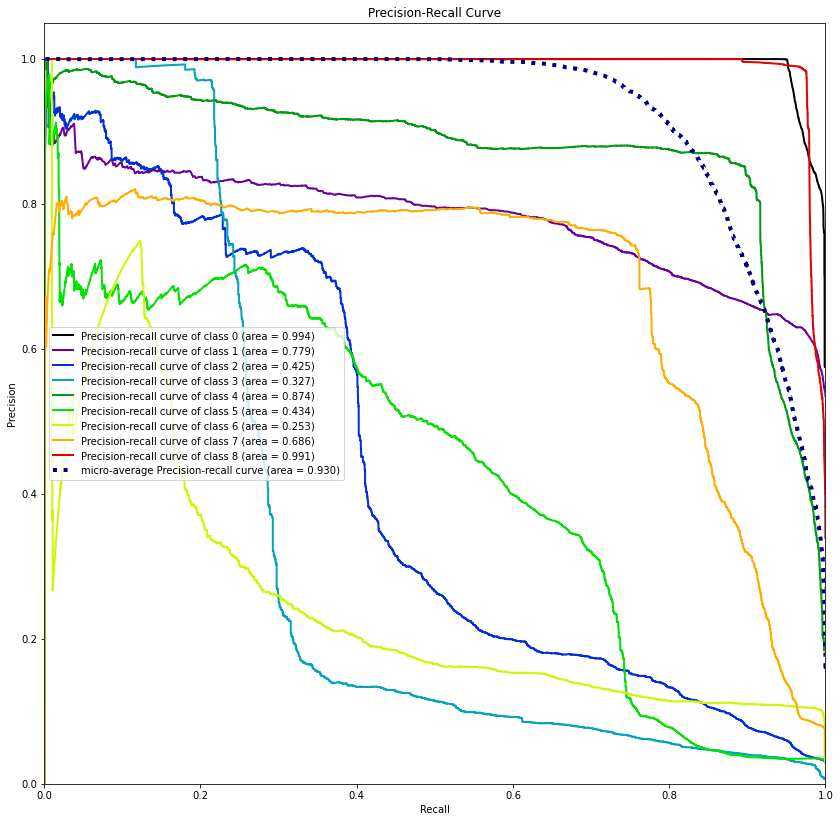

In [111]:
skplt.metrics.plot_precision_recall_curve(actuals,predicted_probabilities)
plt.savefig('three_precision.png')
plt.show()

In [63]:
pd.crosstab(actuals, predicted, dropna=False)

col_0,0,1,2,3,4,5,6,7,8
side,,,,,,,,,
0,402369,13735,413,1182,0,0,5944,154,683
1,30,69370,0,7389,971,20725,30129,5957,0
2,10,333,3453,259,1814,31,2163,446,24
3,2,35,12,1785,1,830,580,359,59
4,0,126,89,1486,42242,856,2085,56,0
5,0,321,0,53,816,5112,560,22,0
6,53,3263,1189,2005,1017,3728,10580,71,64
7,0,208,1470,606,658,12,1028,15580,603
8,7,57,341,539,1511,19,743,0,106699


## Prediction on AI Platform

The following section prepares the data for a Batch Prediction on the AI Platform.

*Note : The Runtime Version we used doesnt support online predictions and hence, we havent demonstrated one with the online predictions. This is because the TensorFlow version that we are using is only available in the said Runtime Version*

### Defining the Configuration Variables

The following cell defines the Configuration Variables. 

*Note: The Model Name and version must match the Model name and Version given to the Model while training. This can be retreived from the Job that was used to create the model.*

In [69]:
MODEL_NAME="Experiment_Three"

REGION = "us-east4"

MODEL_VERSION="v3"

SAVED_MODEL_PATH="gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/{}/export".format(MODEL_NAME,MODEL_VERSION,MODEL_NAME)

INPUT_PATHS = 'gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/predictions/prediction_input.json'.format(MODEL_NAME,MODEL_VERSION)

OUTPUT_PATHS = 'gs://us-gcp-ame-con-01e-npd-1-modelartifacts/{}/{}/predictions/prediction_output'.format(MODEL_NAME,MODEL_VERSION)

DATA_FORMAT = 'text'

JOB_NAME = 'Experiment_Three_v2_Prediction'

! Do not run the next cell if a Model with the above name already exists

In [65]:
!gcloud ai-platform models create $MODEL_NAME \
  --region $REGION

Using endpoint [https://us-east4-ml.googleapis.com/]
Created ml engine model [projects/us-gcp-ame-con-01e-npd-1/models/Experiment_Three].


#### Data Preparation for AI Platform Inference

In [66]:
import json

dictionary_ = transformed_df.to_dict('row')

for value in dictionary_:
    
    for key in value:
        
        value[key] = [value[key]]

with open('prediction_input.json', 'w') as fp:
    
    for dictionary in dictionary_:
        
        json.dump(dictionary, fp)
        
        fp.write("\n")
        

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


Moving the predicted file to Google Storage since AI Platform only allows predictions from there

In [67]:
!gsutil cp -r prediction_input.json $INPUT_PATHS

Copying file://prediction_input.json [Content-Type=application/json]...
- [1 files][124.8 MiB/124.8 MiB]                                                
Operation completed over 1 objects/124.8 MiB.                                    


In [70]:
!gcloud ai-platform jobs submit prediction $JOB_NAME \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATHS \
    --region $REGION \
    --model-dir $SAVED_MODEL_PATH \
    --runtime-version 2.1 \
    --data-format $DATA_FORMAT

Job [Experiment_Three_v2_Prediction] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Experiment_Three_v2_Prediction

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Experiment_Three_v2_Prediction
jobId: Experiment_Three_v2_Prediction
state: QUEUED


#### Retriving the Predictions
Before we retrive the predictions, lets wait till the job completes. We can do this by streaming the logs 

In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

In [ ]:
!gsutil -m cp -r $OUTPUT_PATHS .

In [ ]:

values = []
for file in os.listdir('prediction_output'):
    if "results" in file:
        with open('prediction_output/'+file) as f:
            for line in f:
                dictionary_ = json.loads(line)
                values.append(np.argmax(dictionary_['output_1']))

In [ ]:
np.array(values)

In [ ]:
predicted

The values from the AI Platform job and the In Memory dont match all the time. This is because the AI Platform jobs run out of sequence.

## Resources

* [Google Cloud BigQuery Overview](https://github.com/tensorflow/io/blob/master/tensorflow_io/bigquery/README.md)
* [Training and prediction with Keras in AI Platform](https://colab.sandbox.google.com/github/GoogleCloudPlatform/cloudml-samples/blob/master/notebooks/tensorflow/getting-started-keras.ipynb)